<table>
 <tr align=left><td><img align=left src="https://i.creativecommons.org/l/by/4.0/88x31.png">
 <td>Text provided under a Creative Commons Attribution license, CC-BY. All code is made available under the FSF-approved MIT license. (c) Kyle T. Mandli (and Marc Spiegelman)</td>
</table>

Much of this material was adapted from the first few chapters of [Larson and Bengzon: The Finite Element Method
Theory, Implementation,
and Applications](http://link.springer.com/book/10.1007%2F978-3-642-33287-6).

In [1]:
%matplotlib inline
import numpy
import matplotlib.pyplot as plt

# Finite Element Methods: an introduction

The Finite Element Method (FEM) provides yet another method of transforming continuous PDE's to systems of discrete linear and non-linear equations and is particularly popular in Engineering and Solid Mechanics (although the method is completely general).  Finite Elements has a rich mathematical basis in functional analysis as well a very wide range of specialized applications.  Needless to say, this subject and the accompanying literature is vast.  The purpose of these notes are just to give you a very basic introduction to some of the fundamental ideas in Finite Elements and their implementation.

## Finite Dimensional Function spaces

A key idea in Finite Elements is that we will be approximating continuous functions $f(x)$ as a linear combination of a finite number of basis functions

$$
    f_h(x) = \sum_{i=0}^N w_i \phi_i(x)
$$

where $\phi_i(x)$ are the basis functions and $w_i$ are a set of weights.  We've seen similar decompositions for spectral methods. However instead of using global basis functions such as $\sin(kx)$ or Chebyshev polynomials,  we will (for the most part) use piecewise polynomials.


### Piecewise Linear Functions in 1-D (P1)

![](./images/P1_function_annotated_fig1.1LB.png)

As an example, consider the piecewise linear "connect the dots" function illustrated above where we have decomposed an interval $I=[x_0,x_5]$ into 5 sub-intervals or "elements"  $e_i = [x_{i},x_{i+1}]$ with $i=1\ldots 4$.  Over each of these intervals, the function $v_h$ is a linear function of $x$ and each segment is continuous at the element edge.  Figure modified from Figure 1.1 of Larson and Bengzon.  

While $v_h(x)$ is a continous function that can be evaluated for any value of $x$, it should be clear that there are really only 6 degrees of freedom corresponding to the values at the nodes $\vec v = [v_0,v_1,v_2,v_3,\ldots,v_5]$.  By just changing these 6 numbers, we can generate an infinite number of piecewise linear functions on this triangulation.  We will call this finite dimensional space of functions $\cal V_h$, which is fully described by a mesh of elements, and an interpolant over each element.  

### Global Basis Functions

Given any discrete function space $\cal V_h$, we should be able to describe any function $v_h\in \cal V_h$ in terms of a set of basis functions that span the space.  In the case of a 1-D piecewise linear function space, the global basis functions are given by the "Hat Functions"  

$$
\phi_i(x) = \left\{
\begin{array}{ll}
(x - x_{i-1})/\Delta x_{i-1}, & x\in e_{i-1} \\
(x_i - x)/\Delta x_{i}, & x\in e_{i} \\
0, & \text{otherwise} \\
\end{array}
\right.
$$

Which have the important property that $\phi_i(x_j) = \delta_{ij}$.  A typical hat function is shown in Figure 1.2 from Larson and Bengson.
![](./images/P1_Hat_function_fig1.2LB.png)

While it's not entirely obvious,  we can construct all piecewise linear functions in $\cal V_h$ as a linear combination of these hat functions, i.e. 

$$
f_h(x) = \sum_{i=0}^5 w_i\phi_i(x)
$$

### Local Basis Functions

To make this a bit clearer it is worth looking at how these basis functions interpolate $v$ over a single element.

![](./images/P1LocalBases.png)

> **Figure *3*: Definition of Global and Local Basis Functions**

Consider just the portion of $v(x)$ that lies in element $e_i$.  Clearly the only global basis functions that have support in element $e_i$ are $\phi_i(x)$ and $\phi_{i+1}(x)$.  We claim that over this element
$$
v(x) = v_i\phi_i(x) + v_{i+1}\phi_{i+1}(x)\quad\text{for}\quad x\in [x_i,x_{i+1}]
$$

This is clearly true at the nodes because of the property that $\phi_i(x_j) = \delta_{ij}$.  

Between the nodes, we expect that $\phi_i$ and $\phi_{i+1}$ provide linear interpolation.  If we just consider the *local basis functions* which are the parts of $\phi_i$ and $\phi_{i+1}$ in element $e_i$

\begin{align}
  N_0(x) & = (x_{i+1} - x)/(x_{i+1} - x_i)\\
  N_1(x) & = (x - x_i)/(x_{i+1} - x_i)\\
\end{align}

it becomes clear that these are just the Lagrange Polynomials of order 1 that interpolate any linear function over the interval $[x_i,x_{i+1}]$.   Just to check note that if $x* = x_i + s \Delta x_i$ where $s$ is the fractional distance across the element with length $\Delta x_i = x_{i+1} - x_i$, then
\begin{align}
  N_0(x*) & = (x_{i+1} - x_i -s \Delta x_i)/\Delta x_i = (1 - s)\\
  N_1(x*) & = (x_i + s \Delta x_i - x_i)/\Delta x_i = s\\
\end{align}

so that within $e_i$
$$ 
   v(x) = v_i N_0(x) + v_{i+1}N_1(x) = v_i(1 - s)  + v_{i+1} s
$$
with $s\in[0,1]$

Thus our full function $v(x)$ over the full domain $\Omega = [x_0,x_5]$ is just the union of these local linear pieces.  Throughout this introduction we will often move between the global view and the element view depending on which frame of reference is more convenience.

### Higher order polynomial Function Spaces

The space of piecewise linear functions is often referred to as $P_1$ but there are other choices.  For example, the space of piecewise quadratic functions ($P_2$) has a set of local basis functions that are simply the Lagrange Polynomials of order 2 and require three degrees of freedom per node.  The global basis functions are simply constructed out of the local ones.  The Figure shows a subset of basis functions for $P_2$ which are different for degrees of freedom at the centers and edges of elements (original figure from [Introduction to Finite Element Methods](http://hplgit.github.io/INF5620/doc/pub/sphinx-fem)

![](http://hplgit.github.io/INF5620/doc/pub/sphinx-fem/_images/mpl_fe_basis_p2_4e_lab.png)



## Interpolation of a function $f(x)$ onto $\cal V$

Given a set of basis functions $\phi_i(x)$ for a function space $\cal V$, it should be clear that not all functions can be represented exactly, without error in $\cal V$.  For example, given a smooth function $f(x)$ the question arises how to construct approximations $f_h(x) \in \cal V$ that minimize some measure of the error.  Actually there are multiple approaches.  The simplest approximation is simply the *interpolation* or *projection* of $f$ onto $\cal V$, which we will denote as $\pi f$, and define as the function $\pi f \in \cal V$ such that

$$
    \pi f (x) = \sum_{i=0}^N f(x_i)\phi(x)
$$

Given the interpolating properties of the Lagrange polynomials, it should be clear that

$$
\pi f(x_j) = f(x_j)
$$

i.e. the two functions have zero error at the degrees of freedom. 

Figure 1.3 from Larson and Bengzon shows the linear interpolant of a function $f$ onto a single element over the interval $[x_0,x_1]$.
![](./images/f_interpolation_P1_01.png)

Figure 1.4 from Larson and Bengzon shows the linear interpolant of a function $f$ onto a piecewise linear function space $\cal V$.

![](./images/f_interpolation_P1_02.png)

### Interpolation Errors

In general there will usually be an error between $f(x)$ and its interpolant $\pi f(x)$. Quantifying this error though usually requires defining some norm and as usual there are multiple choices.  As it turns out however,  a useful norm in finite elements is the $L^2$ norm of a function over a domain $\Omega$

$$
    ||f||_{L^2} = \left[ \int_\Omega f^2 dx\right]^{1/2}
$$

and its related norm

$$
    ||f||_{L^2(I)} = \left[ \int_I f^2 dx\right]^{1/2}
$$

over a sub-interval $I$ (usually an element).

Given these definitions, and the behavior of polynomial interpolation it is relatively straightforward to put the following estimates on the interpolation error

* Interpolation error over a single P1 linear element
$$ 
|| f - \pi f||_{L^2(I)} \leq C \Delta x^2||f''||_{L^2(I)}
$$
where $I = [x_i,x{i+1}]$, $\Delta x = x_{i+1} - x_{i}$, C is a constant, and $||f''||_{L^2(I)}$ is a measure of the curvature of the function over the interval.  If $\Delta x=0$ or the function is linear over the interval, then the error is zero.

* Interpolation error over the whole domain
For a piecewise polynomial function, the errors in the interpolant onto $\cal V$ are simply the summation of the errors over the element i.e. 
$$ 
|| f - \pi f||^2_{L^2} \leq C \sum_{i=0}^N \Delta x_i^4||f''||^2_{L^2(I_i)}
$$

### Convergence

Given these error estimates, it is clear that the interpolant converges to the continuous function in the $L^2$ norm as $\Delta x\rightarrow 0$ which makes sense as we expect the interpolant to be a better approximation to $f$ for finer and finer meshes. For $P_1$ functions, the error converges as $\Delta x^2$,  higher order interpolants of *smooth* functions should converge more rapidly if the higher-order piecewise polynomial is a good approximation to the continuous function $f$.

## $L_2$ Projection of a function $f(x)$ onto $\cal V$

While the interpolant $\pi f$ converges to $f$ in the $L^2$ norm as $\Delta x \rightarrow 0$, it turns out that for fixed $\Delta x$, it is not the function in $\cal V$ with the smallest $L^2$ error.  For that problem we need the orthogonal $L^2$ projection $P_h f$ which turns out to be the unique function $v_h\in\cal V$ that minimizes $||f - v_h||_{L^2}$.  
Figure 1.6 from Larson and Bengzon show the orthogonal projection of $f$ onto $\cal V$ for $f(x) = x\sin(\pi x)$

![](./images/f_projection_P1_01.png)


### Relationship to Least-Squares projection in linear algebra

Before we develop the machinery for calculating  the orthogonal $L^2$ projection of $f$ onto $\cal V$, $P_h f$,it is probably worth reviewing, briefly the related orthogonal projection problem from linear algebra. 

![](./images/projection_figure.png)


Consider a 2-dimensional subspace $\cal S$ of $\mathbb R^3$ spanned by two linearly independent 3-D vectors $\boldsymbol{a}_1$ and $\boldsymbol{a}_2$. i.e.

$$
\cal S = \mathrm{span}<\boldsymbol{a}_1,\boldsymbol{a}_2>
$$ 

Let $\boldsymbol{b}$ be a third vector not in $\cal S$.  The problem is to find the point $\boldsymbol{p} \in \cal S$ that minimizes the Euclidian 2-norm of the error $\boldsymbol{e} = \boldsymbol{b} - \boldsymbol{p}$ where $||\boldsymbol{e}||_2 = \sqrt{\boldsymbol{e}^T\boldsymbol{e}}$

Inspection of the figure shows geometrically that the shortest error will be to find the point $\boldsymbol{p} = x_1\boldsymbol{a}_1 + x_2\boldsymbol{a}_2$ such that $\boldsymbol{e}$ is orthogonal to the plane $\cal S$.  If we define a matrix 

$$
A = \begin{bmatrix}
    \boldsymbol{a}_1 & \boldsymbol{a}_2
    \end{bmatrix}
$$

whose columns are the vectors $\boldsymbol{a}_1$ and $\boldsymbol{a}_2$, then $\boldsymbol{p} = A\boldsymbol{x}$ where 

$$
\boldsymbol{x} = \begin{bmatrix}
    x_1\\
    x_2
    \end{bmatrix}
$$

Now for $\boldsymbol{e}$ to be orthogonal to every vector in $\cal S$ it is sufficient for it to be orthogonal to the basis vectors $\boldsymbol{a}_1$ and $\boldsymbol{a}_2$.  Thus the requirement of orthogonality is that 

$$
    \boldsymbol{a}_i^T\boldsymbol{e} = 0
$$

for $i=1,2$.  This is equivalent to the statement $A^T\boldsymbol{e}=\boldsymbol{0}$  (or that the error is in the Left null space of $A$).

But
$$\begin{aligned}
    A^T\boldsymbol{e} & = A^T(\boldsymbol{b} - \boldsymbol{p}) \\
                      & = A^T(\boldsymbol{b} - A\boldsymbol{x}) \\
                      & = \boldsymbol{0}
\end{aligned}$$

or the Least-squares solution requires solving the Normal Equations

$$
    A^TA\boldsymbol{x} = A^T\boldsymbol{b}
$$

(although the numerically sensible  way to solve this is to actually use the QR factorization which is another application of orthogonal projection)

Given a solution $\boldsymbol{x}$, the projection is simply $\boldsymbol{p} = A\boldsymbol{x}$

### Orthogonal Projection of a function onto a discrete Function Space

If you understand the previous problem from linear algebra,  you'll realize that orthogonal projection of a function onto a discrete function space is essentially the same problem with slightly different machinery.  

The problem can be stated:

Given a continuous function $f(x)$ and discrete function space $\cal V_h$,  find the function $P_h f\in \cal V_h$ that minimizes $ || f - P_h f||_{L^2}$.  

Again, we can construct the problem geometrically.  First if $P_h f \in \cal V_h$ then we can write it in terms of the basis functions of $\cal V_h$ i.e.

$$
    P_h f(x)  = \sum_{j=0}^N w_j\phi_j(x)
$$

Next we construct the residual (or error) as

$$ 
    r(x) = f(x) - P_h f(x) 
$$
and require that the residual is "orthogonal" to every function $v_h\in \cal V_h$ where we define orthogonality of functions with respect to the $L^2$ norm in the usual way.  i.e. we say that $f$ and $g$ are orthogonal functions if

$$
    \int_\Omega fg dx = 0
$$

Therefore for $r$ to be orthogonal to every function $v_h\in \cal V_h$, it is only required that it be orthogonal to every basis function of $\cal V_h$.  For a finite dimensional function space the problem becomes find $P_h f \in \cal V_h$ such that

$$ 
    \int_\Omega \phi_i(x) r(x) dx = 0
$$ 
for all $i=0,\ldots,N$.  

Using our definitions for $r(x)$ and $P_h f(x)$, the problem becomes,  find the vector of weights $\boldsymbol{w} = [ w_0, w_1,\ldots, w_N]^T$ such that

$$
    \int_\Omega \phi_i(x)\sum_{j=0}^N w_j\phi_j(x) dx = \int_\Omega \phi_i(x) f(x) dx
$$ 
for all $i=0,\ldots,N$.  

Now the RHS of this equation is a set of $N$ numbers that each describes the $L^2$ inner product of $f$ with each basis function. Defining

$$
    \tilde{f}_i = \int_\Omega \phi_i(x) f(x) dx\quad i=0,\ldots,N
$$
the RHS assembles into a vector $\tilde{\boldsymbol{f}}\in \mathbb R^{N+1}$.  

The LHS is a bit more complicated but we can interchange summation and integration to rewrite the LHS as

$$
\int_\Omega \phi_i(x)\sum_{j=0}^N w_j\phi_j(x) dx = \sum_{j=0}^N w_j\int_\Omega \phi_i(x)\phi_j(x) dx
$$

Now the final definite integrals are another set of doubly indexed numbers

$$
    M_{ij} = \int_\Omega \phi_i(x)\phi_j(x) dx
$$

which define the entries of the "Mass Matrix" $M$.  

Thus the projection problem actually reduces to the linear algebra statement
$$
    \sum_{j=0}^N M_{ij}w_j = \tilde{f}_i
$$
or in matrix-vector notation, solve
$$
    M\boldsymbol{w} = \tilde{\boldsymbol{f}}
$$
for $\boldsymbol{w}$ then $P_h f(x)$ is defined by the weights and basis functions.

![](./images/FEM_projection_assembly.png)

Figure 9 showing all the components needed to assemble the mass matrix $M$ and the load vector $\tilde{\boldsymbol{f}}$

### Structure of the Mass Matrix

To understand the structure of the mass matrix, it is useful to examine the above figure.

Given a 1-D interval with $N$ elements,  the Mass Matrix $M$ is a $N+1\times N+1$ matrix who's components are given by 

$$
    M_{ij} = \int_\Omega \phi_i(x)\phi_j(x) dx
$$

If the basis functions were Orthonormal (e.g. sines and cosines or Chebyshev polynomials) the Mass Matrix would be equal to the Identity $I$.  However,  if the basis functions are hat functions examination of figure 9 shows that it should be sparse as Basis functions that don't share the same support should have $M_{ij}=0$.  For the case of an 1-D problems in $P_1$,  it should be clear that the Mass Matrix should actually be tri-diagonal  as the only non-zero elements will arise from the interaction of a basis function $\phi_i$ and it's two nearest neighbors $\phi_{i-1}$ and $\phi_{i+1}$

In particular,  the $i$th row of $M$ will have three non-zero entries

$$\begin{aligned}
    M_{i,i-1} &= \int_\Omega \phi_{i}\phi_{i-1} dx = \int_{x_{i-1}}^{x_i} \phi_{i}\phi_{i-1} dx \\
    M_{i,i} &= \int_\Omega \phi_{i}\phi_{i} dx = \int_{x_{i-1}}^{x_{i+1}} \phi_{i}\phi_{i} dx \\
    M_{i,i+1} &= \int_\Omega \phi_{i}\phi_{i+1} dx = \int_{x_i}^{x_{i+1}} \phi_{i}\phi_{i+1} dx \\
\end{aligned}$$

Note that the first term is contributed entirely by element $e_{i-1}$, the last term by element $e_i$ and the diagonal entry actually can be split into two parts

$$
    M_{i,i} = \int_{x_{i-1}}^{x_{i}} \phi_{i}\phi_{i} dx + \int_{x_{i}}^{x_{i+1}} \phi_{i}\phi_{i} dx
$$

corresponding to the contributions from both elements $e_{i-1}$ and $e_i$.  For simple  $P_1$ hat functions we can actually calculate these entries analytically (although for more complicated problems or the load matrix we might want to use numerical quadrature).  

If we just consider the first term and use the definitions of $\phi_{i-1}$ and $\phi_i$

$$
    M_{i,i-1} = \int_{x_{i-1}}^{x_i} \frac{x_{i} - x}{\Delta x_{i-1}} \frac{x - x_{i-1}}{\Delta x_{i-1}} dx 
$$

which is straightforward to integrate,  but is easier to do if we first make the affine transformation

$$
 x(t) = x_{i-1} + s \Delta x_{i-1}
$$

where again $s\in [0,1]$ is the fractional distance across element $e{i-1}$ ($s$ is also known as the local element coordinate).  Given this transformation and $dx = \Delta x_{i-1} ds$,  the above integral simplifies to

$$
        M_{i,i-1} = \Delta x_{i-1}\int_{0}^{1} ( 1- s) s ds = \Delta x_{i-1} \left.\left( \frac{s^2}{2} - \frac{s^3}{3}\right)\right|_0^1 = \frac{\Delta x_{i-1}}{6}
$$ 

Using the same approach we can evaluate the remaining terms
$$\begin{aligned}
M_{i,i} &= \Delta x_{i-1}\int_{0}^{1} s^2 ds  + \Delta x_i\int_{0}^{1} (1 - s)^2 ds = \frac{\Delta x_{i-1}}{3} + \frac{\Delta x_i}{3}\\
M_{i,i+1} & = \Delta x_i\int_{0}^{1} s(1-s) ds = \frac{\Delta x_i}{6}
\end{aligned}$$

so the stencil for one row of the mass matrix is simply

$$
M_i = \begin{bmatrix}
   \frac{\Delta x_{i-1}}{6}  & \frac{\Delta x_{i-1}}{3} + \frac{\Delta x_i}{3} & \frac{\Delta x_i}{6}
    \end{bmatrix}
$$

and the Global Mass matrix looks like
$$
    M = \begin{bmatrix}
    \frac{\Delta x_0}{3}  & \frac{\Delta x_0}{6} & & & & \\
    \frac{\Delta x_0}{6}  & \frac{\Delta x_0}{3} + \frac{\Delta x_1}{3} & \frac{\Delta x_1}{6} & & & \\
    &\frac{\Delta x_1}{6}  & \frac{\Delta x_1}{3} + \frac{\Delta x_2}{3} & \frac{\Delta x_2}{6}  & & \\
    & & \ddots & \ddots & \ddots & \\
    & & &   &  \frac{\Delta x_N}{6} & \frac{\Delta x_N}{3}
    \end{bmatrix}
$$

### Mechanics:  Element Wise Assembly 

While it is possible to assemble the global mass matrix as described above,  a better approach is to loop over each element and calculate the local contribution of each element to the global mass matrix.  To begin with we can decompose $M$ into a sum of simpler block matrices

$$
M = \begin{bmatrix}
\frac{\Delta x_0}{3}  & \frac{\Delta x_0}{6} & &  \\
\frac{\Delta x_0}{6}  & \frac{\Delta x_0}{3}  & & \\ 
&&& \\
&&& \\
&&& \\
&&& 
\end{bmatrix} +
\begin{bmatrix}
&&& \\
& \frac{\Delta x_1}{3}  & \frac{\Delta x_1}{6}   & \\ 
& \frac{\Delta x_1}{6}  & \frac{\Delta x_1}{3}  &  \\
&&& \\
&&& \\
&&& 
\end{bmatrix} + \ldots +
\begin{bmatrix}
&&& \\
&&& \\
&&& \\
&&& \\
& & \frac{\Delta x_N}{3}  & \frac{\Delta x_N}{6} \\
& &\frac{\Delta x_N}{6}  & \frac{\Delta x_N}{3}  
\end{bmatrix} 
$$

or

$$
M = M^{e_0} + M^{e_1} + \ldots + M^{e_N}
$$

where 

$$
  M^{e_i} = \frac{\Delta x_i}{6}\begin{bmatrix}
  2 & 1\\
  1 & 2
  \end{bmatrix}
  $$
  
  is the local element Mass Matrix for element $e_i$.  Examination of Figure 3 shows that we can describe the element mass matrix entirely in terms of the local basis functions $N_0(t)$ and $N_1(t)$ in the local coordinate system as
  
$$
  M^{e_i} = \Delta x_i\begin{bmatrix}
  \int_0^1 N_0^2 dt & \int_0^1 N_0N_1 dt \\
  \int_0^1 N_0N_1 dt & \int_0^1 N_1^2 dt 
\end{bmatrix}
$$

and each of these entries correspond to parts (or all) of entries in the global mass matrix

$$
  M^{e_i} = \begin{bmatrix}
  M_{i,i} & M_{i,i+1} \\
  M_{i+1,i} & M_{i+1,i+1} 
\end{bmatrix}
$$

So the overall algorithm is to 
* Loop over elements $i=0,\ldots,N$
* Calculate the local Mass Matrix $M^{e_i}$
* Insert/add into the Global Mass Matrix

A similar process is used to assemble the load vector $\tilde{\boldsymbol{f}}$ by 
* Loop over elements $i=0,\ldots,N$
* Calculate the element contribution to the load vector

$$
    \tilde{\boldsymbol{f}}^{e_i} = \begin{bmatrix}
        \int_{x_{i-1}}^{x_i} N_0(x)f(x) dx \\
        \int_{x_{i-1}}^{x_i} N_1(x)f(x) dx 
        \end{bmatrix} = \begin{bmatrix}
        \tilde{f}_i \\
        \tilde{f}_{i+1} 
        \end{bmatrix}
$$
* Insert/Add into the Global Load Vector



### Convergence/Optimality

For the future...

# Solving 1-D Poisson's using  FEM

The projection problem actually provides most of the machinery required for using the FEM method to solve PDE's.  Here we will consider the simplest 2 pt boundary value problem in 1-D
$$
    -\frac{d^2 u}{dx^2} = f(x)\quad \mathrm{on} \quad \Omega = [0,1] \label{strongform}
$$
with Dirichlet Boundary conditions
$$
    u(0) = u(1) = 0
$$

and if we make it even simpler with $f(x)=1$, we get an easy MMS problem with known solution 

$$
    u(x) = \frac{1}{2}x(1 - x)
$$

The following sections will provide a short recipe for constructing Galerkin Finite element problems

## Choose a function space (Mesh + element)

To begin we will choose a function space $\cal V$ to approximate our discrete function.  First we will subdivide the unit interval with $N$ elements of size $h_j$ (which need not be equal).  Then because we're already familiar with them, we'll approximate our  solution in $P_1$ as a piecewise linear function, i.e. 

$$
    u_h = \sum_{j=0}^N w_j\phi_j(x)
$$

where $\phi(x)$ are the standard hat function basis for $P_1$.  

This may seem an odd choice given that the **strong form** of the PDE, is seeking a function whose second derivative is  constant everywhere and the second derivative of a  $P_1$ function is a set of delta functions at the element edges (ugh) (and even the 1st derivative is piecewise constant functions, but that at least is in $L^2$).

Nevertheless, as we shall see,  this is a perfectly good choice for this problem (as always in some Norm).


## Create the Weak Form

As stated,  the discrete function $u_h(x)$ can not be a solution of (Eq. \ref{strongform})
however,  given any function, we can always calculate a residual by substituting it into the strong form
i.e.

$$
    r(x) = -\frac{d^2 u_h}{dx^2} - f(x).
$$

Obviously if $u_h$ was a solution of (Eq. \ref{strongform}), $r(x)=0$ but given that our particular function space $\cal V$ can not contain strong solutions we can ask the more general problem:

> Find $u_h$ in $\cal V$ that minimizes $||r||_{L^2}$.  

In analogy to the projection problem, we can rephrase the problem as

> Find $u_h$ in $\cal V$ such that
> $$
\int_\Omega v r dx =0
$$
> for all $v$ in $\cal V$.  

In other words find a solution whose residual is orthogonal in the $L^2$ norm to the space of piecewise linear functions on the mesh.

Expanding the residual, the problem becomes

> Find $u_h$ in $\cal V$ such that
> $$
    - \int_\Omega v \frac{d^2 u_h}{dx^2} dx  = \int_\Omega vf dx \label{eq:weak_form}
$$
> for all $v$ in $\cal V$.

### Some Terminology

Equation $\eqref{eq:weak_form}$ is known as the **weak form** or **variational form** of the problem.  In addition there is some other common terminology that arises in FEM.  In general we refer to

- $u_h$ as the *trial function* (i.e. the function we are trying in the residual)
- $v$ is the *test function*  (i.e. any function in $\cal V$ that we are testing orthogonality)
- The LHS of Eq. \eqref{eq:wf}
$$
    a(u_h,v) = -\int_\Omega v \frac{d^2 u_h}{dx^2} dx
$$
is a **bilinear form** $a(u,v)$ that takes two functions $u$ and $v$ as arguments and is linear in both arguments
- The RHS of Eq. \eqref{eq:wf}
$$
    L(v) = \int_\Omega vf dx 
$$
is a **linear form** $L(v)$ which evaluates as a scalar for every function $v$
- A short hand that is often used to describe these variational problems is 
$$
    a(u,v) = L(v)
$$

### Integrate by parts

The bilinear form on the LHS of Eq \eqref{eq:wf} is still somewhat problematic (particularly if $u_h$ is in $P_1$) but one of the beautiful features of variational forms is that we can always apply integration by parts to transfer some of the derivatives off of the trial-function and on to the test function.  Given that 

$$
    \frac{d^2 u_h}{dx^2} = \frac{d}{dx}\frac{du_h}{dx}
$$

and standard product rule gives
$$
    \frac{d}{dx} \left(v \frac{du_h}{dx}\right) = v\frac{d^2 u}{dx^2} + \frac{dv}{dx}\frac{du_h}{dx}
$$

It follows that

$$\begin{aligned}
a(u_h,v) &= -\int_\Omega v \frac{d^2 u_h}{dx^2} dx \\
        &= \int_\Omega \frac{dv}{dx}\frac{du_h}{dx} dx - \int_\Omega \frac{d}{dx} \left(v \frac{du_h}{dx}\right) dx \\
        &= \int_\Omega \frac{dv}{dx}\frac{du_h}{dx} dx - \left. v \frac{du_h}{dx}\right|_{\partial\Omega}
\end{aligned}$$

where the last term depends on the test function and first derivative of $u_h$ evaluated on the boundary of the domain (and thus Neumann or flux boundary conditions are very naturally included in Finite element formulations).

If we neglect the surface terms for the moment,  integration by parts has now transformed the bilinear form to 

$$
    a(u_h,v) = \int_\Omega \frac{dv}{dx}\frac{du_h}{dx} dx 
$$ 

which depend only on the gradients of the test and trial functions which in $P_1$ are piecewise constant.



### The weak form for a finite dimensional function space

All of the above terminology and ideas apply to both infinite dimensional and finite dimensional functions spaces.  However for a finite dimensional function space with a fixed number of basis functions,  the various linear and bilinear forms actually reduce to linear algebraic operators.  We've already seen this in the case of the projection problem and the structure of the problem is the same for Poisson.  

We start by expressing our test function in terms of the basis functions
$$
    u_h(x) = \sum_{j=0}^N w_j\phi_j(x)
$$

and choose as our test functions, each of the basis functions in term so that the variational problem $a(v,u_h)=L(v)$ actually becomes

- Find $\boldsymbol{w}\in R^{N+1}$ such that

$$
    \int_\Omega \frac{d\phi_i}{dx} \sum_{j=0}^N w_j \frac{d\phi_i}{dx} dx = \int_\Omega \phi_i f dx
$$

or exchanging integration and summation we can write the problem as 

$$
     \sum_{j=0}^N w_j \int_\Omega \frac{d\phi_i}{dx}\frac{d\phi_i}{dx} dx = \int_\Omega \phi_i f dx
$$

or

$$
    \sum_{j=0}^N A_{ij}w_j = \tilde{f}_i
$$

where

$$ 
    A_{ij} = \int_\Omega \frac{d\phi_i}{dx}\frac{d\phi_i}{dx} dx \quad \tilde{f}_i = \int_\Omega \phi_i f dx
$$

or simply 

$$
A\boldsymbol{w} = \tilde{\boldsymbol{f}}
$$

where $A$ is the **stiffness Matrix** and $\tilde{\boldsymbol{f}}$ is the **load vector** (Note: a lot of finite element terminology came out of its application to elasticity problems in engineering and thus words like stiffness and load have crept in to the nomenclature.  While it's true that the eigenvalues of A for Poisson can lead to stiff problems in ODE settings, this has nothing to do with the name Stiffness matrix.)

In other words,  the weak form of the PDE Eq. \eqref{strongform}  transforms to $A\boldsymbol{w} = \tilde{\boldsymbol{f}}$   in the same way that the the weak form of the projection problem $u_h = f$ transforms to $M\boldsymbol{w} = \tilde{\boldsymbol{f}}$ where $M$ is the mass matrix and the load vector is exactly the same.

## Assembly

Assembly of the global stiffness matrix and global load vector procedes in exactly the same manner as with the projection problem (and in fact the load vector is the same in the two problems).  The only slight issue is that the stiffness matrix now contains derivatives of the basis functions, rather than the basis functions themselves.  However it is straightforward to work out all the details for $P_1$ elements.

Again we begin by assembling the **element** stiffness matrix

$$
  A^{e_i} = \begin{bmatrix}
  \int_{x_i}^{x_{i+1}} \frac{dN_0}{dx}^2 dx & \int_{x_i}^{x_{i+1}} \frac{dN_0}{dx}\frac{dN_1}{dx} dx \\
  \int_{x_i}^{x_{i+1}} \frac{dN_0}{dx}\frac{dN_1}{dx} dx & \int_{x_i}^{x_{i+1}} \frac{dN_1}{dx}^2 dx \\
\end{bmatrix}
$$

where  
$$
    N_0(x) = \frac{x_{i+1} - x}{\Delta x_i} \quad N_1(x) = \frac{x - x_i}{\Delta x_i}
$$
are the local element basis functions (or shape functions) which in this case are just the Lagrange Polynomials of order 1. 

Under the standard affine transformation $x = x_{i} + t h_i$,  we transform these again to local coordinates such that
$$
    N_0(t) = 1 - t \quad N_1(t) = t
$$

And apply

$$
    \frac{dN_i}{dx} = \frac{dN_i}{dt}\frac{dt}{dx} = \frac{1}{\Delta x_i}\frac{dN_i}{dt}
$$

so for example the first term in the element stiffness matrix becomes
$$
    A^{e_i}_{00} = \frac{1}{\Delta x_i}\int_0^1 dt = \frac{1}{\Delta x_i}
$$

and the element stiffness matrix becomes 

$$
    A^{e_i} = \frac{1}{\Delta x_i}\begin{bmatrix}
    1 & -1 \\
    -1 & 1 \\
    \end{bmatrix}
$$

Assembly of the global stiffness matrix proceds in the same manner with a stencil for an interior point
$$
M_i = \begin{bmatrix}
   -\frac{1}{\Delta x_{i-1}}  & \frac{1}{\Delta x_{i-1}} + \frac{1}{\Delta x_i} & \frac{1}{\Delta x_i}
    \end{bmatrix}
$$

which for a regularly spaced mesh with $h_0,\ldots,h_N = h$ is simply
$$
M_i = \frac{1}{\Delta x}\begin{bmatrix}
   -1 & 2 & -1
    \end{bmatrix}
$$

which is our classic second order centered finite difference stencil for the second derivative
and the Global Mass matrix looks rather familiar as 
$$
    M = \frac{1}{\Delta x}\begin{bmatrix}
    1  & -1 & & & & \\
    -1 & 2 & -1 & & & \\
    &-1  & 2 & -1  & & \\
    & & \ddots & \ddots & \ddots & \\
    & & &   &  -1 & 2
    \end{bmatrix}
$$

Thus at least for Poisson with constant forcing and a 1-D mesh, $P_1$ Galerkin Finite Elements gives exactly the same discretization as second order finite differences.

## Boundary conditions

To complete the discription of the discrete form of this elliptic PDE problem we need to apply boundary conditions.
In the case of Neumann Flux conditions,  these are readily incorporated into the assembly of the weak forms. Integration by parts of the bilinear form generated another term
$$
\left. v \frac{du_h}{dx}\right|_{\partial\Omega}
$$

which we have ignored so far, but is consistent with a no-flux condition $\frac{du_h}{dx}=0$.  More general Neumann condition states that $\frac{du_h}{dx}$ is known on the boundary, for example the gradient is some known constant $\frac{du_h}{dx}=\alpha$.  In this case we just subsitute $\alpha$ for the gradient in the term above which is now only a function of the test function $v$ and get's evaluated and added to the load vector.

Dirichlet BC's are (as usual) somewhat more complicated and can be implemented in multiple ways, similar to how they were done in finite difference problems.  The cleanest way is to note that if the boundary is of known value,  that degree of freedom is not really in the function space and we just solve starting with the first interior point and adjust the RHS as necessary. However when reconstructing the function we need to remember to insert the proper value on the boundaries.

Other approaches include assembling the problem as before and then as a post-assembly step, modifying the matrix to put 1's on the diagonal, zero the rest of the row and insert the appropriate values in the load vector.  This often can lead to a loss of symmetry of the stiffness matrix however, so a better approach is to zero both row and columns and adjust the RHS accordingly.  

# Advanced Software for Finite Element Modeling

While it is not difficult to write a toy Python script to implement all the steps for solving the Poisson problem in 1-D with linear elements,  writing it in a way that is extensible and modular so that it can be extended to higher dimensions, different elements, different solvers etc.  is a daunting task.  Fortunately,  smarter people than me have already develop a wide range of both commercial and open-source FEM libraries and applications. I list a few of the more popular ones at the end of these notes.

However,  one that is particularly interesting, both mathematically and computationally is [FEnICS](http://fenicsproject.org) from the fenicsproject.org.  


![](http://fenicsproject.org/_static/fenics_banner.png)

(okay that is way to big an image but Jupyter doesn't seem to be able to let me size images)

Anyway,  the FEniCS project provides a set of libraries and computational tools for the rapid design and exploration of PDE based problems using the Finite Element Method.  A brief description of its interesting features are
- Provides both C++ and python interfaces to its core libraries
- Includes a python-like high-level language (UFL, the unified form language) for the description of weak forms that look pretty much like the integrals we write here.  In particular UFL supports
-- a wide range of continuous and discontinuous elements (see the [Periodic Table of Finite Elements](http://femtable.org/)
-- high level vector and tensor operators (Div, Grad, Curl)
-- Automatic differentian of Forms (very useful for non-linear problems)
- FFC: The FEniCS Form Compiler  a python program that takes UFL and does automatic code generation to create custom compileable C++ for the assembly of complicated forms on Elements.
- DOLFIN:  the main set of libraries for handling meshes, assembly, solvers and IO/visualization.  In particular it has multiple solver backends to Advanced solver libraries like [PETSc](https://www.mcs.anl.gov/petsc/) and [Trilinos](https://trilinos.org/)

But it's actually easier to look at a Python demo to understand how it works.  The following piece of code is modified from one of their well documented demos for solving Poisson equations but modified to the 1-D problem we have been discussing.

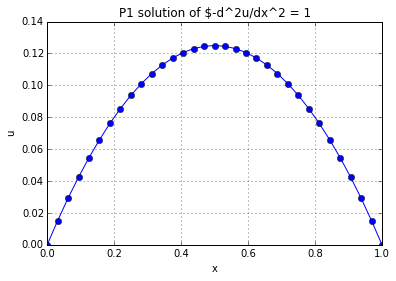

In [19]:
"""This demo program solves Poisson's equation in 1-D

    - d^2 u/ dx^2  = f(x)

on the unit interval with source f given by

    f(x) = 1

and homogeneous Dirichlet boundary conditions given by

    u(0)=u(1) = 0        for x = 0 or x = 1
"""

# Modified from demo_poisson.py from the FEniCS demos


# Begin demo

from dolfin import *

# Create mesh and define function space
mesh = UnitIntervalMesh(32)
V = FunctionSpace(mesh, "Lagrange", 1)

# Define Dirichlet boundary (x = 0 or x = 1)
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 1.0 - DOLFIN_EPS

# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(1.)
a = v.dx(0)*u.dx(0)*dx
L = f*v*dx 

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Save solution in VTK format
file = File("poisson.pvd")
file << u


# Plot solution using Fenics plotting software
#plot(u, interactive=True)

# Extract coordinates and values at  vertices and plot using matplotlib

x = mesh.coordinates().T[0]
uh = u.vector().array()

plt.figure()
plt.plot(x,uh,'bo-')
plt.xlabel('x')
plt.ylabel('u')
plt.title('P1 solution of $-d^2u/dx^2 = 1')
plt.grid()

And here is the same problem but with a Neumann BC on the right hand side such that $du_h/dx = \alpha$ which simply adds one more term to  the Linear form which comes from the surface integrals of the bilinear form

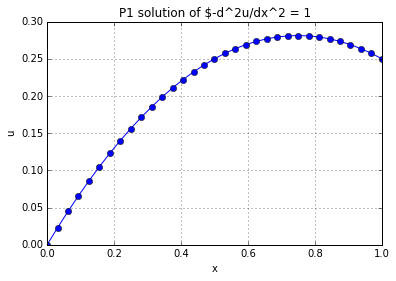

In [20]:
"""This demo program solves Poisson's equation in 1-D

    - d^2 u/ dx^2  = f(x)

on the unit interval with source f given by

    f(x) = 1

and boundary conditions given by

    u(0)= 0        for x = 0 
    du/dx = alpha for x=1
"""

# Modified from demo_poisson.py from the FEniCS demos


# Begin demo

from dolfin import *

# Create mesh and define function space
mesh = UnitIntervalMesh(32)
V = FunctionSpace(mesh, "Lagrange", 1)

# Define Dirichlet boundary (x = 0 )
def boundary(x):
    return x[0] < DOLFIN_EPS 

# Define boundary condition
# Dirichlet
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)
# Neumann:  du/dx = \alpha
alpha=Constant(-.25)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
f = Constant(1.)
a = v.dx(0)*u.dx(0)*dx
L = v*f*dx + v*alpha*ds

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Save solution in VTK format
file = File("poisson.pvd")
file << u

# Plot solution using Fenics plotting software
#plot(u, interactive=True)

# Extract coordinates and values at  vertices and plot using matplotlib

x = mesh.coordinates().T[0]
uh = u.vector().array()

plt.figure()
plt.plot(x,uh,'bo-')
plt.xlabel('x')
plt.ylabel('u')
plt.title('P1 solution of $-d^2u/dx^2 = 1')
plt.grid()

## Finite Elements in higher dimensions

One of the beautiful features of FEniCS is that it allows you to write and solve higher dimensional PDE's with about the same amount of work as the 1-D problem.  As an example we will consider the following problem and it's FEniCS implementation.

### Strong Form

Solve a generalized Poisson problem on a rectangle

$$
    -\nabla\cdot \alpha(x)\nabla u = f(x) \quad \mathrm{on} \quad \Omega=[0,2]\times[0,1]
$$

where $\alpha(x,y) > 0$ on $\Omega$ ($\alpha=1$ is just Poisson) and source term 

$$
    f(\boldsymbol{x}) = 10 \exp\left[ -((x - 1)^2 + (y - 1/2)^2)/0.02\right]
$$ 

and Dirichlet BC's in the x direction
$$
    u(0,y) = u(2,y) =0
$$

and Neumann Flux Boundary conditions on the y boundaries
$$
    \alpha(x)\nabla u\cdot\hat{n} = \sin(5x) \quad \mathrm{on} \quad y=0,1
$$
 
### Weak form

To form the weak form we choose a function space $\cal V$, for example piecewise linear functions over triangles, and solver the variational problem,  

> Find $u$ in $\cal V$ such that 

$$ 
    -\int_\Omega v\nabla\cdot \alpha\nabla u dx = \int_\Omega vf dx
$$
for all $v$ in $\cal V$.

Again, integrating the bilinear problem by parts gives

\begin{align}
    -\int_\Omega v\nabla\cdot (\alpha \nabla u) dx &= \int_\Omega \nabla v\cdot (\alpha \nabla u) dx - \int_\Omega \nabla\cdot v(\alpha\nabla u) dx \\
    & = \int_\Omega \nabla v\cdot (\alpha \nabla u) dx - \int_{\partial\Omega}  v (\alpha\nabla u\cdot\hat{n}) ds \\
\end{align}

where we have applied Gauss's divergence theorem to the last term to move the integrals to the boundary where we know the Neumann BC's.

In the language of variational forms,  the weak form can be described as $a(u,v) = L(v)$ where

\begin{align}
    a(u,v) &= \int_\Omega \nabla v\cdot \alpha \nabla u dx \\
    L(v) &= \int_\Omega vf dx + \int_{\partial\Omega}  v g ds \\
\end{align}

where 

$$
    g(x,y) = \alpha\nabla u\cdot\hat{n} = \sin(5x)
$$

Remarkably, the FEniCS code for this problem looks very much like what we just wrote down.
 

In [21]:
"""This demo program solves Poisson's equation

    - div alpha(x,y) grad u(x, y) = f(x, y)

on the a rectangular domain [0,2]x[0,1] with source f given by

    f(x, y) = 10*exp(-((x - 0.5)^2 + (y - 0.5)^2) / 0.02)

and boundary conditions given by

    u(x, y) = 0        for x = 0 or x = 2
alpha\grad u . n (x,y) = sin(5*x) for y = 0 or y = 1
"""

# modified from Dolfin Poisson demo_poisson.py

# Copyright (C) 2007-2011 Anders Logg
#
# This file is part of DOLFIN.
#
# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.
#
# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.
#
# First added:  2007-08-16
# Last changed: 2012-11-12

# Begin demo

from dolfin import *

# Create mesh and define function space
mesh = RectangleMesh(Point(0.,0.),Point(2.,1.),64, 32,"right")
V = FunctionSpace(mesh, "Lagrange", 1)

# Define Dirichlet boundary (x = 0 or x = 2)
def boundary(x):
    return x[0] < DOLFIN_EPS or x[0] > 2.0 - DOLFIN_EPS

# Define boundary condition
u0 = Constant(0.0)
bc = DirichletBC(V, u0, boundary)

# Define variational problem
u = TrialFunction(V)
v = TestFunction(V)
alpha = Constant(1.)
#a = Expression("1. + 0.5*sin(8*x[0])*sin(4*x[1])")
f = Expression("10*exp(-(pow(x[0] - 0.5, 2) + pow(x[1] - 0.5, 2)) / 0.02)")
g = Expression("sin(5*x[0])")
a = inner(grad(v),alpha*grad(u))*dx
L = v*f*dx + v*g*ds

# Compute solution
u = Function(V)
solve(a == L, u, bc)

# Save solution in VTK format
file = File("poisson.pvd")
file << u


# Plot solution
plot(u, interactive=True)


<dolfin.cpp.io.VTKPlotter; proxy of <Swig Object of type 'std::shared_ptr< dolfin::VTKPlotter > *' at 0x126599270> >

![](./images/FEniCS_2D_figure.png)

Figure 10 showing solution of 2D poisson problem with mixed dirichlet, Neumann BC's calculated using FEniCS and visualized using Paraview/

# Other software

### Open Source
- TerraFERMA
- FEAP
- ...

### Commercial
- Abaqus
- Comsol
- ...

# Onwards and upwards with FEM:  an incomplete list

- Adding time dependence
- Exotic elements 
- Stability of element choices
- Hyperbolic and Parabolic equations
- Non-linear equations
- Effective solver choices
- Multi-physics
- and on and on